In [1]:
import matplotlib.pyplot as plt
import numpy as np
import snntorch as snn
import snntorch.functional as SF
from snntorch import spikeplot as splt
import snntorch.spikegen as spikegen
import torch
from torch import nn
from torch.optim import Adam

In [11]:
class MultimodalIntegration(nn.Module):
	"""
	Combine the outputs from the visual and auditory encoders into a single multimodal representation.
	"""

	def __init__(self, input_size, hidden_size, output_size, beta):
		super(MultimodalIntegration, self).__init__()

		self.flatten = nn.Flatten()
		self.fc1 = nn.Linear(input_size, hidden_size)
		self.lif1 = snn.Leaky(beta=beta)
		self.fc2 = nn.Linear(hidden_size, hidden_size)
		self.lif2 = snn.Leaky(beta=beta)
		self.fc3 = nn.Linear(hidden_size, output_size)
		self.lif3 = snn.Leaky(beta=beta)

	def forward(self, x):
		x = self.flatten(x.to(torch.float32))
		#print(f"Shape after flattening: {x.shape}")
		mem1 = self.lif1.init_leaky()
		mem2 = self.lif2.init_leaky()
		mem3 = self.lif3.init_leaky()
		cur1 = self.fc1(x)
		spk1, mem1 = self.lif1(cur1, mem1)
		cur2 = self.fc2(spk1)
		spk2, mem2 = self.lif2(cur2, mem2)
		cur3 = self.fc3(spk2)
		spk3, mem3 = self.lif3(cur3, mem3)
		return spk3, mem3

In [174]:

# ## Hyperparameters
beta = 0.9  # Decay rate of the LIF neuron
hidden_size = 128  # Size of the hidden layer
output_size = 10  # Output size for the final multimodal representation
input_size = 40  # Correct input size based on concatenation of visual and auditory spikes

# Load the visual outputs file
sensory_data = np.load('paired_input_noise_0p1.npy')
all_labels = np.load('all_labels.npy')
labels = all_labels[1,:].copy()

In [175]:
# Concatenate the encoded spikes
combined_spikes = torch.from_numpy(sensory_data)

net = MultimodalIntegration(input_size, hidden_size, output_size, beta)


In [176]:

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.01)

targets = torch.from_numpy(labels)

In [177]:
# Training loop
num_epochs = 10
# num_samples = min(vis_spikes.shape[0], aud_spikes.shape[0], targets.shape[0])  # Use the minimum size across datasets 512
#num_samples = 3000

num_steps = 81  # Number of timesteps for the spike train

for epoch in range(num_epochs):
	epoch_loss = 0.0

	for i in range(np.size(sensory_data, 0)):

		target = targets[i].unsqueeze(0)

		# Initialize hidden states
		mem1 = net.lif1.init_leaky()
		mem2 = net.lif2.init_leaky()
		mem3 = net.lif3.init_leaky()

		# Accumulate loss over timesteps
		total_loss = 0.0
		optimizer.zero_grad()

		for t in range(num_steps):
			# Flatten the spike train for the current timestep
			input_t = combined_spikes[i,:,t].unsqueeze(0)

			# Forward pass through the network for each timestep
			spk3, mem3 = net(input_t)

			# Compute loss for this timestep
			loss = loss_fn(spk3, target.long())
			total_loss += loss

		# Backward pass and optimization
		optimizer.zero_grad()
		total_loss.backward()
		optimizer.step()

		epoch_loss += total_loss.item()

	avg_loss = epoch_loss / np.size(sensory_data, 0)
	print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

print("Training complete")


Epoch 1/10, Loss: 135.8660
Epoch 2/10, Loss: 130.5921
Epoch 3/10, Loss: 129.9983
Epoch 4/10, Loss: 129.7593
Epoch 5/10, Loss: 129.5895
Epoch 6/10, Loss: 129.5007
Epoch 7/10, Loss: 129.4407
Epoch 8/10, Loss: 129.2170
Epoch 9/10, Loss: 129.1660
Epoch 10/10, Loss: 129.1319
Training complete


In [178]:
batch = 512
correct_preds = 0
false_preds = 0
with torch.no_grad():
  net.eval()
  for i in range(np.size(sensory_data, 0)):
    target = targets[i].unsqueeze(0)
    for t in range(num_steps):
      input = combined_spikes[i,:,t].unsqueeze(0)
      spk, mem = net(input)
      if np.argmax(mem) == target:
        correct_preds += 1
      else:
        false_preds += 1

In [179]:
correct_preds / (correct_preds + false_preds)

0.8468460648148148

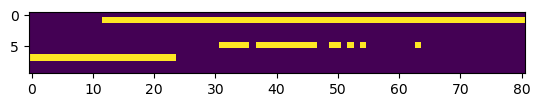

In [94]:
plt.imshow(outputs.detach().numpy()[:,0,:].T)

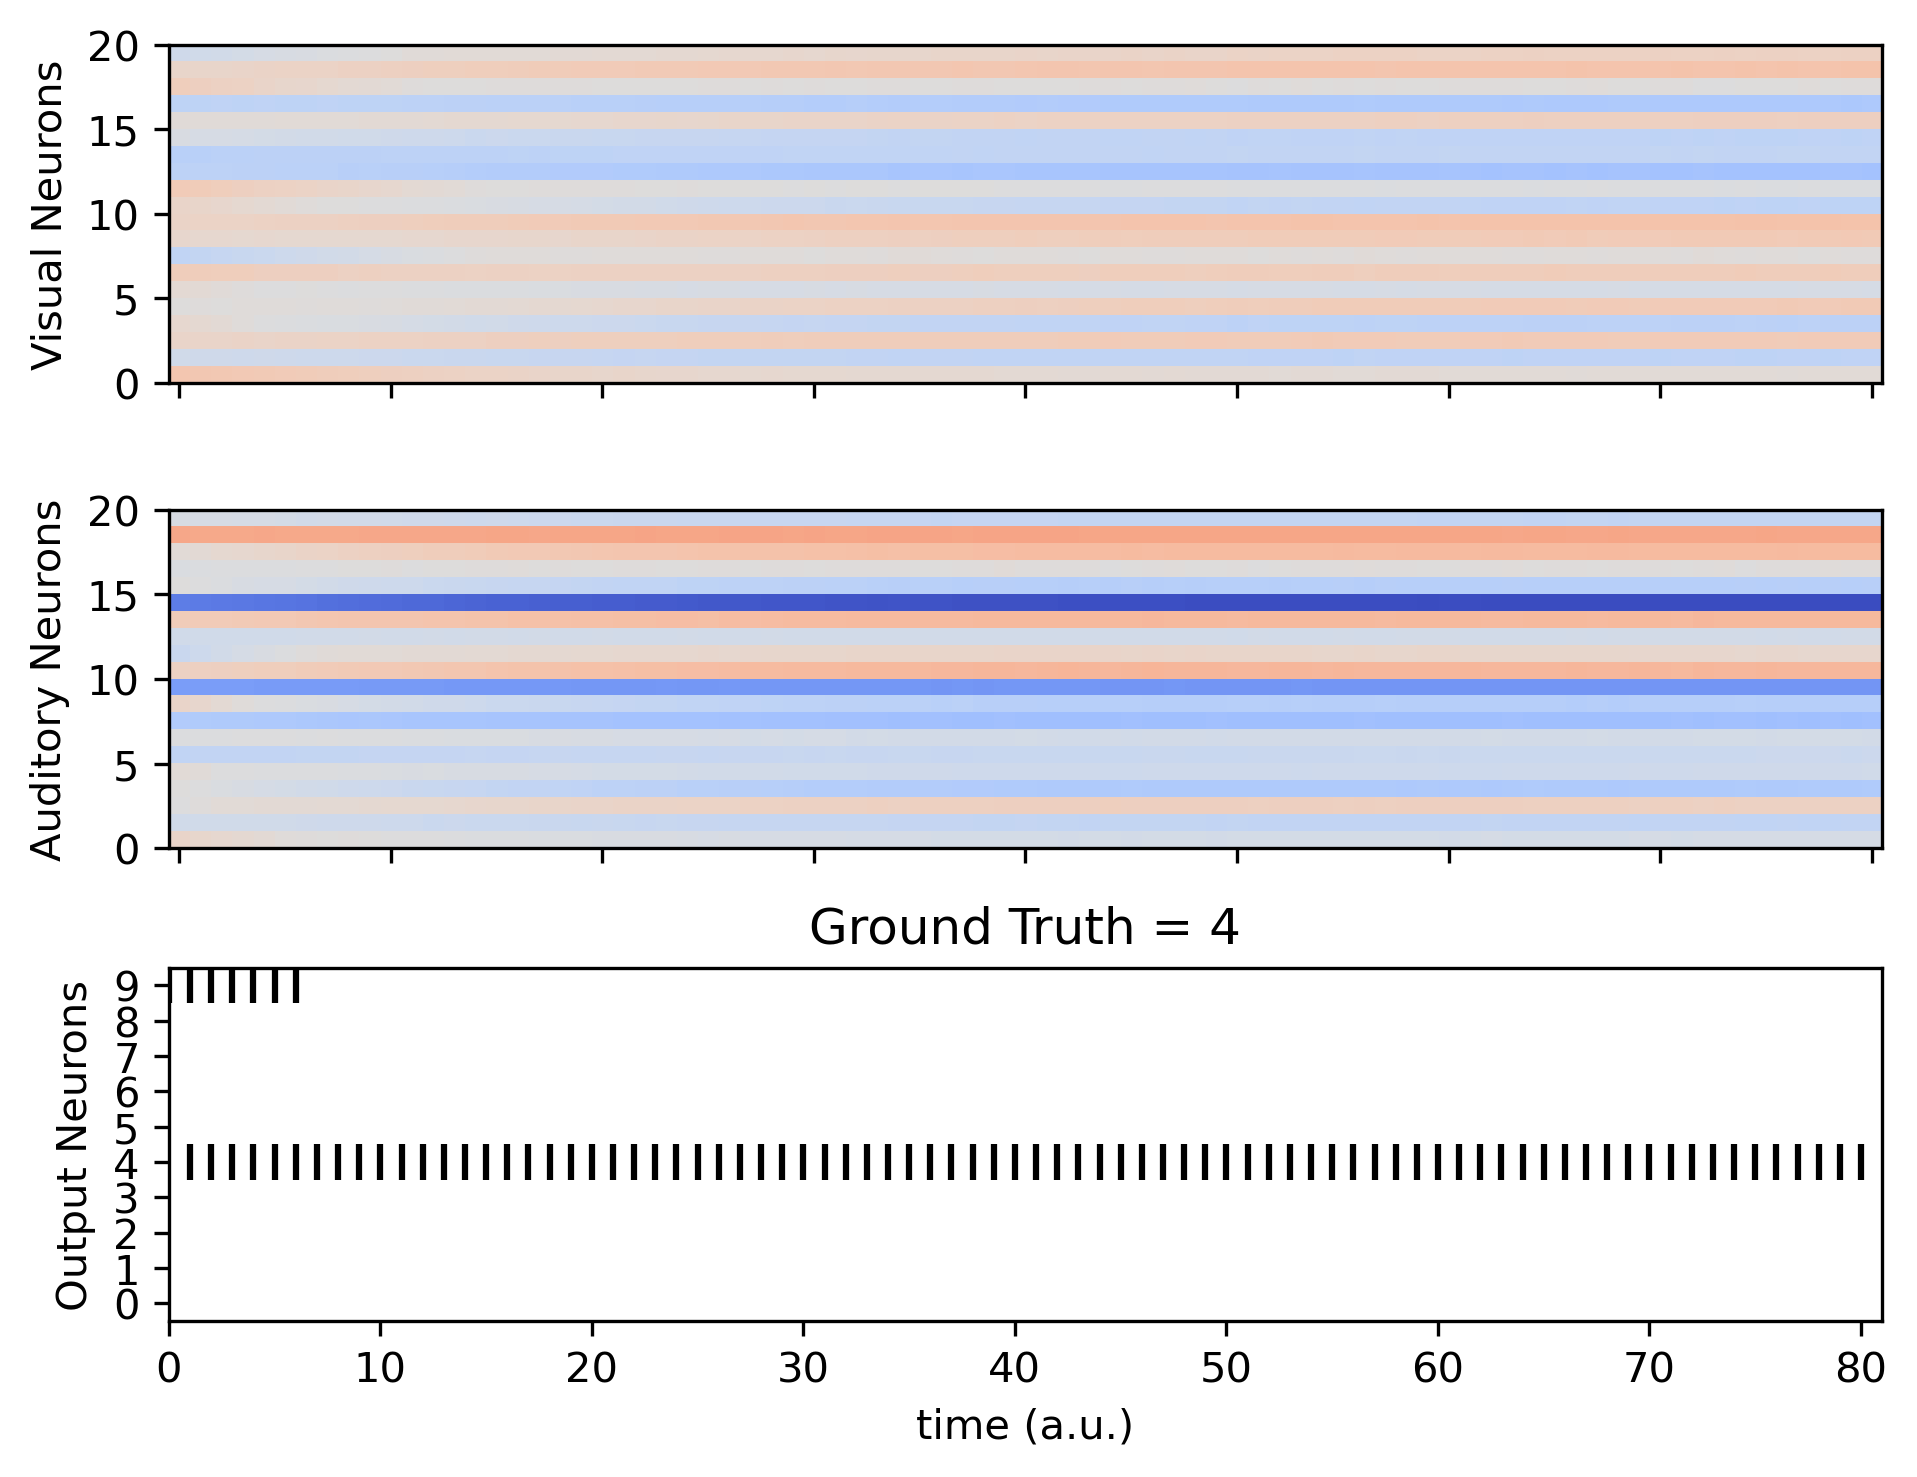

In [122]:
outputs = []
memV = []

ex = 5

num_time_points = 81
for t in range(num_time_points):
	input_t_rate = combined_spikes[ex,:,t]
	sp, mem = net(input_t_rate.unsqueeze(0))
	outputs.append(sp)
	memV.append(mem)

outputs = torch.stack(outputs)
memV = torch.stack(memV)

fig, [ax1,ax2,ax3] = plt.subplots(3,1, dpi=300, figsize=(6.5,5))

set_min = combined_spikes[ex].min().numpy()
set_max = combined_spikes[ex].max().numpy()

set_abs_max = np.max(np.abs([set_min, set_max]))
set_min = -set_abs_max
set_max = set_abs_max

ax1.imshow(combined_spikes[ex,:20,:], vmin=set_min, vmax=set_max, cmap='coolwarm', aspect=0.8)
ax2.imshow(combined_spikes[ex,20:,:], vmin=set_min, vmax=set_max, cmap='coolwarm', aspect=0.8)

ax1.invert_yaxis()
ax2.invert_yaxis()
ax1.set_yticks(np.linspace(-0.5,19.5,5), labels=np.linspace(0,20,5).astype(int))
ax2.set_yticks(np.linspace(-0.5,19.5,5), labels=np.linspace(0,20,5).astype(int))

ax1.set_xticklabels([])
ax2.set_xticklabels([])
for i in range(10):
	ax3.vlines(np.argwhere(outputs.detach().numpy()[:,0,i]).flatten(), i-0.5, i+0.5, color='k')
ax3.set_ylim([-0.5,9.5])
ax3.set_yticks(np.arange(10), labels=np.arange(10).astype(int))

ax1.set_ylabel('Visual Neurons')
ax2.set_ylabel('Auditory Neurons')
ax3.set_ylabel('Output Neurons')

ax3.set_xlabel('time (a.u.)')
ax3.set_xlim([0,81])
ax3.set_title('Ground Truth = {}'.format(int(labels[ex])))

fig.tight_layout()

In [180]:
params = [param for param in net.parameters()]

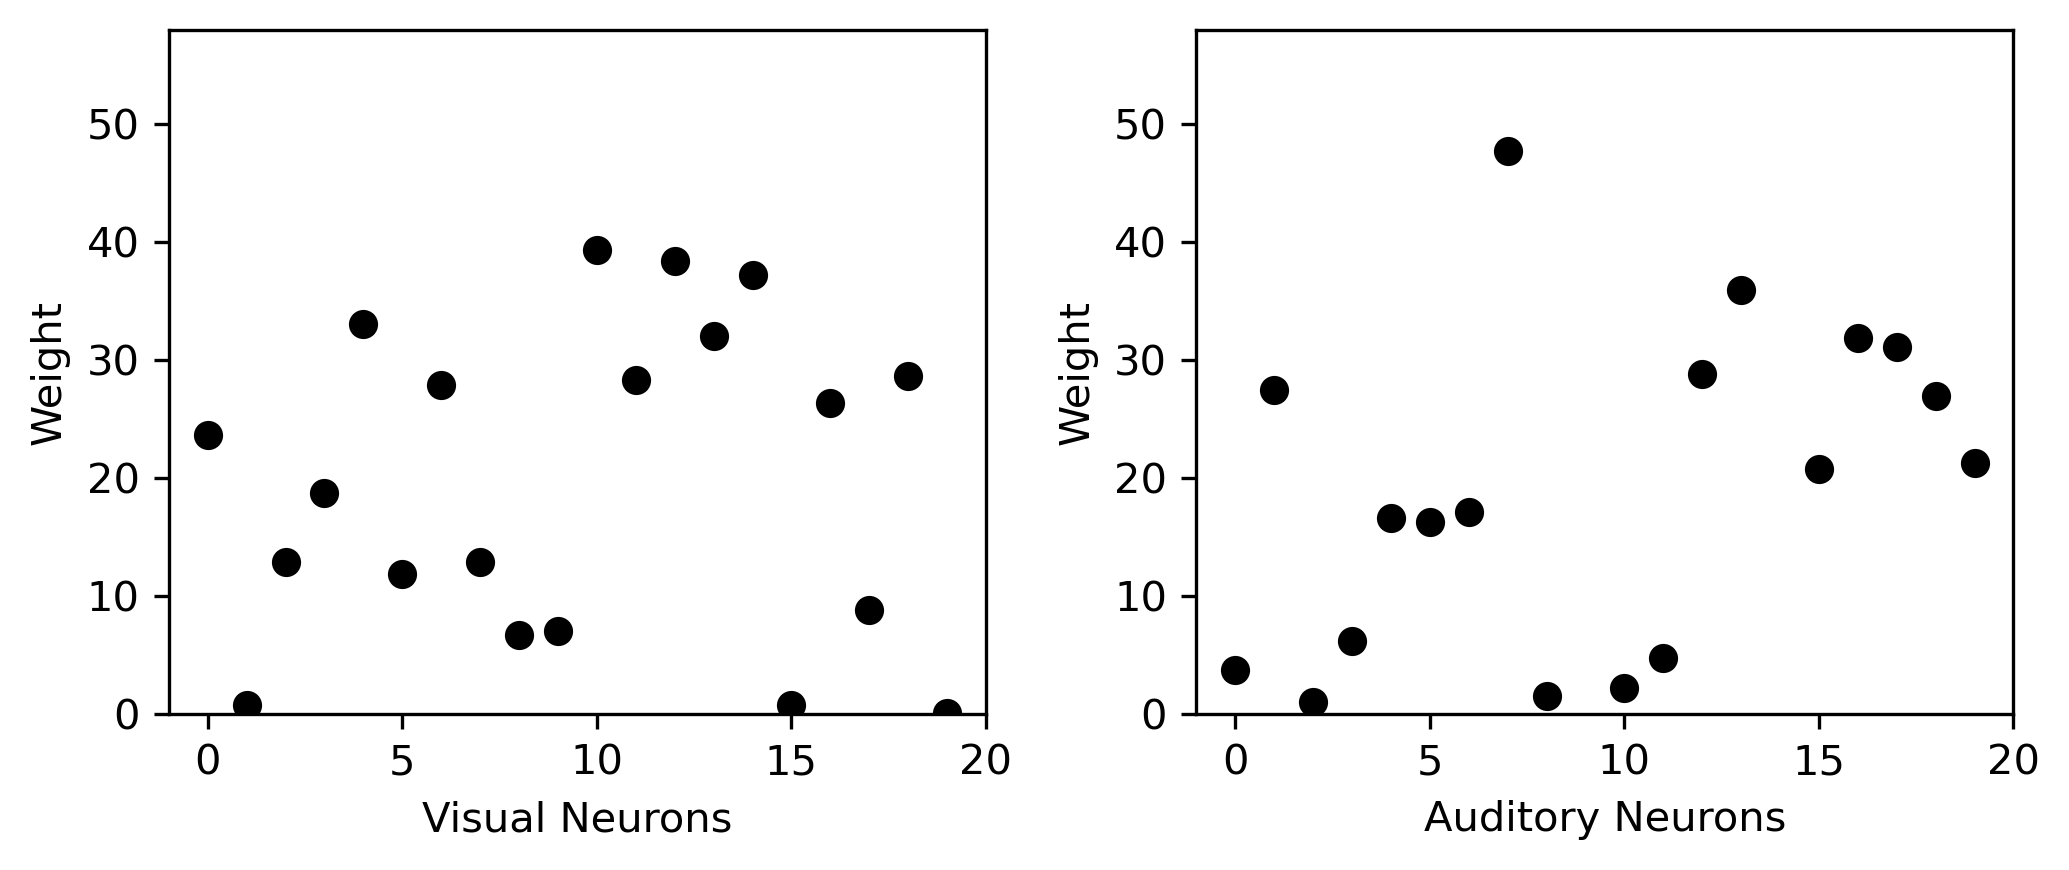

In [181]:
l1_weights = np.abs(params[0].sum(0).detach().numpy())

fig, [ax1,ax2] = plt.subplots(1,2, dpi=300, figsize=(7,3))

ax1.plot(l1_weights[:20], 'ko')
ax1.set_xlim([-1,20])
ax1.set_ylim([0,58])
# ax1.set_title('visual mean={:.2f}'.format(l1_weights[:20].mean()))

ax2.plot(l1_weights[20:], 'ko')
ax2.set_xlim([-1,20])
ax2.set_ylim([0,58])
# ax2.set_title('auditory mean={:.2f}'.format(l1_weights[20:].mean()))

ax1.set_ylabel('Weight')
ax1.set_xlabel('Visual Neurons')

ax2.set_xlabel('Auditory Neurons')
ax2.set_ylabel('Weight')

fig.tight_layout()

In [160]:
def jitter(x, sz, scale):
    return x + np.random.uniform(-scale, scale, sz)

array([ 0.07367264,  0.04200178, -0.09404657,  0.03517565, -0.05169933,
        0.00428481,  0.02692531, -0.01362013,  0.06953284,  0.07522706])

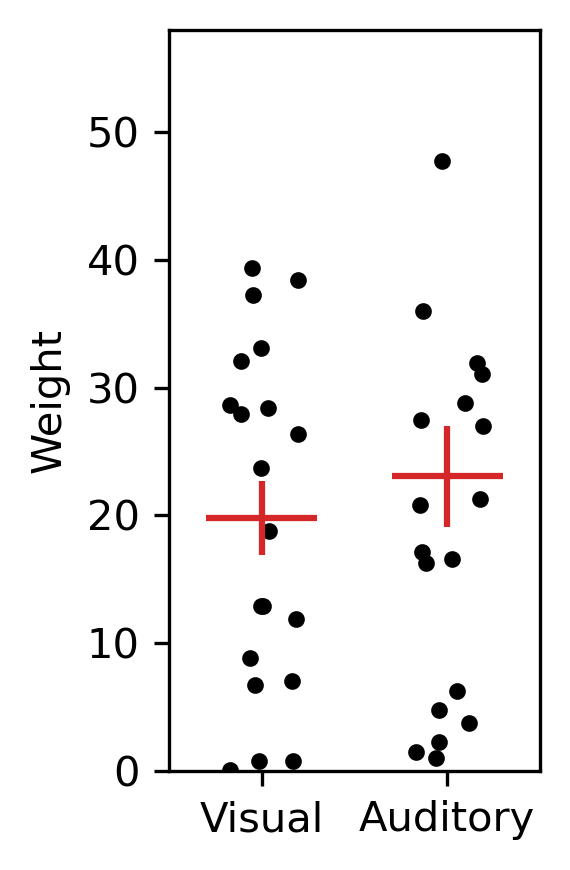

In [182]:
fig, ax1 = plt.subplots(1,1, dpi=300, figsize=(2,3))
ax1.plot(jitter(0, 20, 0.2), l1_weights[:20], 'k.')
ax1.plot(jitter(1, 20, 0.2), l1_weights[20:], 'k.')
ax1.set_xlim([-0.5,1.5])
ax1.set_ylim([0,58])
ax1.set_xticks([0,1], labels=['Visual','Auditory'])
ax1.hlines(l1_weights[:20].mean(), -0.3, 0.3, color='tab:red')
ax1.hlines(l1_weights[20:].mean(), 0.7, 1.3, color='tab:red')
v_stderr = l1_weights[:20].std() / np.sqrt(20)
a_stderr = l1_weights[20:].std() / np.sqrt(20)
ax1.vlines(
    0,
    l1_weights[:20].mean()-v_stderr,
    l1_weights[:20].mean()+v_stderr,
    color='tab:red'
)
ax1.vlines(
    1,
    l1_weights[20:].mean()-a_stderr,
    l1_weights[20:].mean()+a_stderr,
    color='tab:red'
)
ax1.set_ylabel('Weight')
fig.tight_layout()

In [ ]:
for i in ['0', '0p1', '0p2', '0p5', '1p0']:
    for j in ['0', '0p1', '0p2', '0p5', '1p0']:

ValueError: x and y must have same first dimension, but have shapes torch.Size([81, 20]) and (1,)

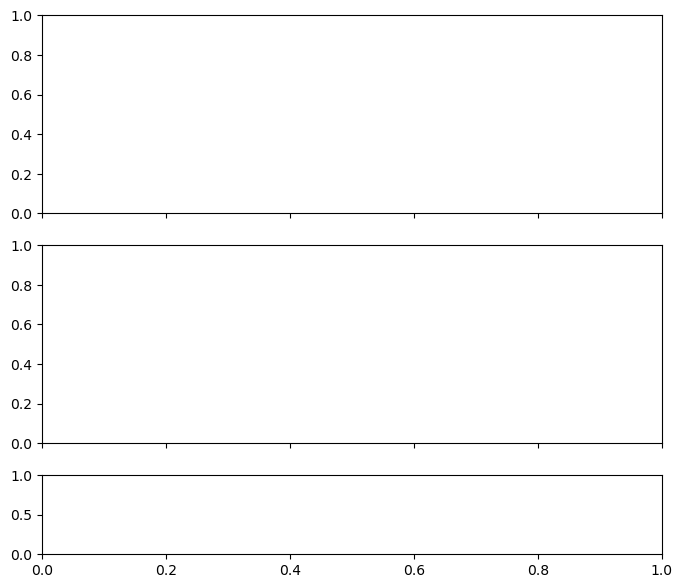

In [43]:
fig, ax = plt.subplots(3, figsize=(8, 7), sharex=True,
						gridspec_kw={'height_ratios': [1, 1, 0.4]})

# Plot hidden layer spikes
#splt.raster(visual_spk, ax[0], s=5, c="black")
plt.plot(combined_spikes[ex,:20,:].T, ax[0], s=5, c="black", marker="|")

ax[0].set_ylabel("Vision Hidden")

# Plot hidden layer spikes
splt.raster(combined_spikes[ex,20:,:].T, ax[1], s=5, c="black")
ax[1].set_ylabel("Audio Hidden")

# Plot output spikes
splt.raster(outputs[:,0,:], ax[2], c="black", marker="|")
ax[2].set_ylabel("Output")

# ax[0].set_ylim((-2.45, 51.45))
# ax[1].set_ylim((-2.45, 51.45))
# ax[2].set_ylim([0, 9])

plt.tight_layout()
plt.show()

# %% [markdown]
# ### Visual and audio the same

# do_and_plot_model_inference(combined_spikes, targets, ex=1)

# %% [markdown]
# ### Vision good but audio random


In [12]:

do_and_plot_model_inference(vis_spikes, aud_spikes, targets, ex=1)

# %% [markdown]
# # Questions and todo
# 
# * include audio hidden output
# * how to convert multimodal output spike train into final answer


torch.Size([1, 81, 20])


torch.Size([1, 81, 20])
torch.Size([81, 40])
Vision Input: shape=torch.Size([1, 81, 20]), spikes=947.0
Audio: shape=torch.Size([1, 81, 20]), spikes=441.0
Output: shape=torch.Size([81, 1, 10]), spikes=243.0
Memvrane potential: shape=torch.Size([81, 1, 10]), Max potential=np.maxtensor([[[  63.9802,   79.0848,   33.2360, -465.8821, -458.8828, -457.5385,
          -412.2772, -475.3934, -444.2844, -471.9661]],

        [[  63.9802,   79.0848,   33.2360, -465.8821, -458.8828, -457.5385,
          -412.2772, -475.3934, -444.2844, -471.9661]],

        [[  63.9802,   79.0848,   33.2360, -465.8821, -458.8828, -457.5385,
          -412.2772, -475.3934, -444.2844, -471.9661]],

        [[  63.9802,   79.0848,   33.2360, -465.8821, -458.8828, -457.5385,
          -412.2772, -475.3934, -444.2844, -471.9661]],

        [[  63.9802,   79.0848,   33.2360, -465.8821, -458.8828, -457.5385,
          -412.2772, -475.3934, -444.2844, -471.9661]],

        [[  63.9802,   79.0848, 